In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the new dataset
df = pd.read_csv("simulated_river_data_large.csv")

# Separate features and target
X = df[['pH', 'turbidity', 'temperature', 'DO']]
y = df['anomaly']

# Feature scaling (optional but improves performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Example: Prediction on new data
new_data = [[6.5, 30.1, 22.3, 4.2]]  # pH, turbidity, temperature, DO
new_data_scaled = scaler.transform(new_data)

prediction = model.predict(new_data_scaled)
print("Prediction for new data:", "Anomaly Detected!" if prediction[0] == 1 else "Normal")

KeyError: 'anomaly_flag'

In [2]:
import pandas as pd

df = pd.read_csv("simulated_river_data_large.csv")
print(df.columns.tolist())

['pH', 'turbidity', 'temperature', 'DO', 'anomaly']


In [5]:
import pandas as pd

df = pd.read_csv("simulated_river_data_large.csv")
print(df.columns.tolist())

['pH', 'turbidity', 'temperature', 'DO', 'anomaly']


In [6]:
X = df[['pH', 'turbidity', 'temperature', 'DO']]
y = df['anomaly']

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Load the new dataset
df = pd.read_csv("simulated_river_data_large.csv")

# Separate features and target
X = df[['pH', 'turbidity', 'temperature', 'DO']]
y = df['anomaly']

# Feature scaling (optional but improves performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train the RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Example: Prediction on new data
new_data = [[6.5, 30.1, 22.3, 4.2]]  # pH, turbidity, temperature, DO
new_data_scaled = scaler.transform(new_data)

prediction = model.predict(new_data_scaled)
print("Prediction for new data:", "Anomaly Detected!" if prediction[0] == 1 else "Normal")

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         8

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26

Prediction for new data: Anomaly Detected!


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [8]:
# Example new sensor reading: [pH, turbidity, temperature, DO]
new_data = [[6.5, 30.1, 22.3, 4.2]]

# Scale the new data using the same scaler used during training
new_data_scaled = scaler.transform(new_data)

# Predict with the trained model
prediction = model.predict(new_data_scaled)

# Print result
print("🧪 Prediction for new data point:")
print("🔴 Anomaly Detected!" if prediction[0] == 1 else "🟢 Normal")

🧪 Prediction for new data point:
🔴 Anomaly Detected!


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
import joblib
joblib.dump(model, "river_anomaly_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [10]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import asyncio
from sse_starlette.sse import EventSourceResponse

app = FastAPI()

# Enable CORS
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

# Mock database
sensor_data = []

@app.on_event("startup")
async def startup_event():
    """Generate initial mock data"""
    global sensor_data
    now = datetime.now()
    for i in range(24):  # 24 hours of historical data
        sensor_data.append({
            "timestamp": (now - timedelta(hours=i)).isoformat(),
            "sensor_id": 1,
            "ph": 7.0 + 0.5 * np.sin(i/3),
            "nitrates": 20 + 10 * np.sin(i/2),
            "turbidity": 15 + 5 * np.random.rand()
        })

@app.get("/stream")
async def stream_data():
    """SSE endpoint for real-time updates"""
    async def event_generator():
        while True:
            # Simulate new data every 2 seconds
            new_data = {
                "timestamp": datetime.now().isoformat(),
                "sensor_id": 1,
                "ph": 7.0 + 0.5 * np.sin(len(sensor_data)/3),
                "nitrates": 20 + 10 * np.sin(len(sensor_data)/2),
                "turbidity": 15 + 5 * np.random.rand()
            }
            sensor_data.append(new_data)
            yield {
                "event": "update",
                "data": json.dumps(new_data)
            }
            await asyncio.sleep(2)
    
    return EventSourceResponse(event_generator())

@app.get("/historical")
async def get_historical():
    """Get last 24 hours of data"""
    return sensor_data[-24:]
import streamlit as st
import requests
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import time
import json

# Config
BACKEND_URL = "http://localhost:8000"
UPDATE_INTERVAL = 2  # seconds

# Initialize session state
if "data" not in st.session_state:
    st.session_state.data = pd.DataFrame()

# Dashboard UI
st.set_page_config(layout="wide")
st.title("🌊 Live River Monitoring Dashboard")

# Create placeholder containers
chart_ph = st.empty()
status_col1, status_col2, status_col3 = st.columns(3)

def fetch_initial_data():
    """Get historical data"""
    try:
        response = requests.get(f"{BACKEND_URL}/historical")
        return pd.DataFrame(response.json())
    except:
        return pd.DataFrame()

def update_chart(df):
    """Update Plotly chart with live data"""
    fig = go.Figure()
    
    # Add traces
    fig.add_trace(go.Scatter(
        x=df["timestamp"],
        y=df["ph"],
        name="pH",
        line=dict(color="royalblue", width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=df["timestamp"],
        y=df["nitrates"],
        name="Nitrates (ppm)",
        yaxis="y2",
        line=dict(color="firebrick", width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=df["timestamp"],
        y=df["turbidity"],
        name="Turbidity (NTU)",
        yaxis="y3",
        line=dict(color="green", width=2)
    ))
    
    # Layout
    fig.update_layout(
        title="Water Quality Parameters (Live)",
        xaxis_title="Time",
        yaxis=dict(title="pH", side="left"),
        yaxis2=dict(title="Nitrates", overlaying="y", side="right"),
        yaxis3=dict(title="Turbidity", overlaying="y", side="right", anchor="free", position=0.85),
        hovermode="x unified",
        height=500
    )
    
    chart_ph.plotly_chart(fig, use_container_width=True)

def update_status(df):
    """Update status metrics"""
    if not df.empty:
        latest = df.iloc[-1]
        with status_col1:
            st.metric("pH", f"{latest['ph']:.2f}", delta=f"{(latest['ph'] - df.iloc[-2]['ph']):.2f}")
        with status_col2:
            st.metric("Nitrates", f"{latest['nitrates']:.1f} ppm", delta=f"{(latest['nitrates'] - df.iloc[-2]['nitrates']):.1f}")
        with status_col3:
            st.metric("Turbidity", f"{latest['turbidity']:.1f} NTU", delta=f"{(latest['turbidity'] - df.iloc[-2]['turbidity']):.1f}")

# Initialize with historical data
if st.session_state.data.empty:
    st.session_state.data = fetch_initial_data()

# Set up SSE connection for live updates
if "sse" not in st.session_state:
    st.session_state.sse = requests.get(f"{BACKEND_URL}/stream", stream=True)

# Main loop
while True:
    try:
        # Process SSE events
        for line in st.session_state.sse.iter_lines():
            if line.startswith("data:"):
                new_point = json.loads(line[5:])
                new_df = pd.DataFrame([new_point["data"]])
                st.session_state.data = pd.concat([st.session_state.data, new_df]).tail(24)
                
                # Update UI
                update_chart(st.session_state.data)
                update_status(st.session_state.data)
                
    except:
        st.error("Connection lost. Reconnecting...")
        st.session_state.sse = requests.get(f"{BACKEND_URL}/stream", stream=True)
        time.sleep(1)

ModuleNotFoundError: No module named 'fastapi'

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your CSV
df = pd.read_csv("simulated_river_data_large.csv")

# Add a timestamp column
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')

# Fill missing
df = df.fillna(method='bfill').fillna(method='ffill')

# Normalize features
features = ['pH', 'turbidity', 'temperature', 'DO']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Create sequences
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['anomaly'].iloc[i])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=30, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


ModuleNotFoundError: No module named 'tensorflow'

In [12]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your CSV
df = pd.read_csv("simulated_river_data_large.csv")

# Add a timestamp column
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')

# Fill missing
df = df.fillna(method='bfill').fillna(method='ffill')

# Normalize features
features = ['pH', 'turbidity', 'temperature', 'DO']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Create sequences
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['anomaly'].iloc[i])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=30, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


ModuleNotFoundError: No module named 'tensorflow'

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your CSV
df = pd.read_csv("simulated_river_data_large.csv")

# Add a timestamp column
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')

# Fill missing
df = df.fillna(method='bfill').fillna(method='ffill')

# Normalize features
features = ['pH', 'turbidity', 'temperature', 'DO']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Create sequences
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['anomaly'].iloc[i])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=30, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


ModuleNotFoundError: No module named 'tensorflow'

In [15]:
import tensorflow as tf
print(tf._version_)

ModuleNotFoundError: No module named 'tensorflow'

In [16]:
!{sys.executable} -m pip install tensorflow

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
import sys
!{sys.executable} -m pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow


In [18]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import asyncio
from sse_starlette.sse import EventSourceResponse

app = FastAPI()

# Enable CORS
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

# Mock database
sensor_data = []

@app.on_event("startup")
async def startup_event():
    """Generate initial mock data"""
    global sensor_data
    now = datetime.now()
    for i in range(24):  # 24 hours of historical data
        sensor_data.append({
            "timestamp": (now - timedelta(hours=i)).isoformat(),
            "sensor_id": 1,
            "ph": 7.0 + 0.5 * np.sin(i/3),
            "nitrates": 20 + 10 * np.sin(i/2),
            "turbidity": 15 + 5 * np.random.rand()
        })

@app.get("/stream")
async def stream_data():
    """SSE endpoint for real-time updates"""
    async def event_generator():
        while True:
            # Simulate new data every 2 seconds
            new_data = {
                "timestamp": datetime.now().isoformat(),
                "sensor_id": 1,
                "ph": 7.0 + 0.5 * np.sin(len(sensor_data)/3),
                "nitrates": 20 + 10 * np.sin(len(sensor_data)/2),
                "turbidity": 15 + 5 * np.random.rand()
            }
            sensor_data.append(new_data)
            yield {
                "event": "update",
                "data": json.dumps(new_data)
            }
            await asyncio.sleep(2)
    
    return EventSourceResponse(event_generator())

@app.get("/historical")
async def get_historical():
    """Get last 24 hours of data"""
    return sensor_data[-24:]
import streamlit as st
import requests
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import time
import json

# Config
BACKEND_URL = "http://localhost:8000"
UPDATE_INTERVAL = 2  # seconds

# Initialize session state
if "data" not in st.session_state:
    st.session_state.data = pd.DataFrame()

# Dashboard UI
st.set_page_config(layout="wide")
st.title("🌊 Live River Monitoring Dashboard")

# Create placeholder containers
chart_ph = st.empty()
status_col1, status_col2, status_col3 = st.columns(3)

def fetch_initial_data():
    """Get historical data"""
    try:
        response = requests.get(f"{BACKEND_URL}/historical")
        return pd.DataFrame(response.json())
    except:
        return pd.DataFrame()

def update_chart(df):
    """Update Plotly chart with live data"""
    fig = go.Figure()
    
    # Add traces
    fig.add_trace(go.Scatter(
        x=df["timestamp"],
        y=df["ph"],
        name="pH",
        line=dict(color="royalblue", width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=df["timestamp"],
        y=df["nitrates"],
        name="Nitrates (ppm)",
        yaxis="y2",
        line=dict(color="firebrick", width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=df["timestamp"],
        y=df["turbidity"],
        name="Turbidity (NTU)",
        yaxis="y3",
        line=dict(color="green", width=2)
    ))
    
    # Layout
    fig.update_layout(
        title="Water Quality Parameters (Live)",
        xaxis_title="Time",
        yaxis=dict(title="pH", side="left"),
        yaxis2=dict(title="Nitrates", overlaying="y", side="right"),
        yaxis3=dict(title="Turbidity", overlaying="y", side="right", anchor="free", position=0.85),
        hovermode="x unified",
        height=500
    )
    
    chart_ph.plotly_chart(fig, use_container_width=True)

def update_status(df):
    """Update status metrics"""
    if not df.empty:
        latest = df.iloc[-1]
        with status_col1:
            st.metric("pH", f"{latest['ph']:.2f}", delta=f"{(latest['ph'] - df.iloc[-2]['ph']):.2f}")
        with status_col2:
            st.metric("Nitrates", f"{latest['nitrates']:.1f} ppm", delta=f"{(latest['nitrates'] - df.iloc[-2]['nitrates']):.1f}")
        with status_col3:
            st.metric("Turbidity", f"{latest['turbidity']:.1f} NTU", delta=f"{(latest['turbidity'] - df.iloc[-2]['turbidity']):.1f}")

# Initialize with historical data
if st.session_state.data.empty:
    st.session_state.data = fetch_initial_data()

# Set up SSE connection for live updates
if "sse" not in st.session_state:
    st.session_state.sse = requests.get(f"{BACKEND_URL}/stream", stream=True)

# Main loop
while True:
    try:
        # Process SSE events
        for line in st.session_state.sse.iter_lines():
            if line.startswith("data:"):
                new_point = json.loads(line[5:])
                new_df = pd.DataFrame([new_point["data"]])
                st.session_state.data = pd.concat([st.session_state.data, new_df]).tail(24)
                
                # Update UI
                update_chart(st.session_state.data)
                update_status(st.session_state.data)
                
    except:
        st.error("Connection lost. Reconnecting...")
        st.session_state.sse = requests.get(f"{BACKEND_URL}/stream", stream=True)
        time.sleep(1)

ModuleNotFoundError: No module named 'fastapi'

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your CSV
df = pd.read_csv("simulated_river_data_large.csv")

# Add a timestamp column
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')

# Fill missing
df = df.fillna(method='bfill').fillna(method='ffill')

# Normalize features
features = ['pH', 'turbidity', 'temperature', 'DO']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Create sequences
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['anomaly'].iloc[i])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=30, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2124\3615844259.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


ModuleNotFoundError: No module named 'tensorflow'

In [1]:
pip install ipykernel
python -m ipykernel install --user --name your-env-name --display-name "Python (your-env-name)"

SyntaxError: invalid syntax (2966902957.py, line 1)

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your CSV
df = pd.read_csv("simulated_river_data_large.csv")

# Add a timestamp column
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')

# Fill missing
df = df.fillna(method='bfill').fillna(method='ffill')

# Normalize features
features = ['pH', 'turbidity', 'temperature', 'DO']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Create sequences
sequence_length = 10
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df['anomaly'].iloc[i])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=30, batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=1)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13484\3615844259.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='H')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13484\3615844259.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
c:\Users\ASUS\anaconda3\envs\pollutrack-env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.5961 - loss: 0.6785 - val_accuracy: 0.7917 - val_loss: 0.6269
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7524 - loss: 0.6298 - val_accuracy: 0.7917 - val_loss: 0.5663
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7798 - loss: 0.5636 - val_accuracy: 0.7917 - val_loss: 0.5233
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7615 - loss: 0.5564 - val_accuracy: 0.7917 - val_loss: 0.5111
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7618 - loss: 0.5530 - val_accuracy: 0.7917 - val_loss: 0.5112
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7615 - loss: 0.5489 - val_accuracy: 0.7917 - val_loss: 0.5110
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7838 - loss: 0.5144 - val_accuracy: 0.7917 - val_loss: 0.5124
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7305 - loss: 0.5891 - val_accuracy: 0.7917 - val_loss: 0.5162

c:\Users\ASUS\anaconda3\envs\pollutrack-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\envs\pollutrack-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\anaconda3\envs\pollutrack-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Sample sensor data: [pH, turbidity, temperature]
x = torch.tensor([
    [7.0, 1.2, 25.0],  # Node 0
    [6.5, 2.0, 24.0],  # Node 1
    [5.8, 3.5, 23.5],  # Node 2 (polluted)
    [6.9, 1.1, 25.5],  # Node 3
    [5.4, 4.0, 23.0]   # Node 4 (polluted)
], dtype=torch.float)

# Edges: river flow connections
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3, 3, 4],
    [1, 0, 2, 1, 3, 2, 4, 3]
], dtype=torch.long)

# Labels: 0 = clean, 1 = polluted
y = torch.tensor([0, 0, 1, 0, 1], dtype=torch.long)

# Masks for training and testing
train_mask = torch.tensor([True, True, True, False, False])
test_mask = torch.tensor([False, False, False, True, True])

# Create the graph object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

In [4]:
from torch.nn import Module
from torch_geometric.nn import GCNConv

class GCN(Module):
    def _init_(self, in_channels, hidden_channels, out_channels):
        super(GCN, self)._init_()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [6]:
print(data)
print(data.x.shape)       # Node features
print(data.edge_index)    # Connectivity
print(data.y)             # Labels
print(data.train_mask)    # Training mask

Data(x=[5, 3], edge_index=[2, 8], y=[5], train_mask=[5], test_mask=[5])
torch.Size([5, 3])
tensor([[0, 1, 1, 2, 2, 3, 3, 4],
        [1, 0, 2, 1, 3, 2, 4, 3]])
tensor([0, 0, 1, 0, 1])
tensor([ True,  True,  True, False, False])


In [7]:
out = model(data)
print("Output shape:", out.shape)
print("Target shape:", data.y[data.train_mask].shape)
print("Output example:", out[data.train_mask])
print("Target example:", data.y[data.train_mask])

NameError: name 'model' is not defined

In [8]:
import torch.nn.functional as F

# Make sure model and data are already defined and moved to device
out = model(data)

# Print diagnostics
print("Output shape:", out.shape)
print("Target shape:", data.y[data.train_mask].shape)
print("Output example:\n", out[data.train_mask])
print("Target example:\n", data.y[data.train_mask])

NameError: name 'model' is not defined

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=3, hidden_channels=8, out_channels=2).to(device)
data = data.to(device)

TypeError: GCN.__init__() got an unexpected keyword argument 'in_channels'

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=3, hidden_channels=8, out_channels=2).to(device)
data = data.to(device)  # Move your data to the same device

TypeError: GCN.__init__() got an unexpected keyword argument 'in_channels'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=3, hidden_channels=8, out_channels=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

TypeError: GCN.__init__() got an unexpected keyword argument 'in_channels'

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=3, hidden_channels=8, out_channels=2).to(device)
data = data.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 3.8101
Epoch 10, Loss: 0.9358
Epoch 20, Loss: 0.6715
Epoch 30, Loss: 0.7005
Epoch 40, Loss: 0.6281
Epoch 50, Loss: 0.6157
Epoch 60, Loss: 0.5952
Epoch 70, Loss: 0.5826
Epoch 80, Loss: 0.5668
Epoch 90, Loss: 0.5507


In [16]:
model.eval()
out = model(data)
pred = out.argmax(dim=1)
correct = pred[data.test_mask] == data.y[data.test_mask]
accuracy = int(correct.sum()) / int(data.test_mask.sum())
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


Matplotlib is building the font cache; this may take a moment.


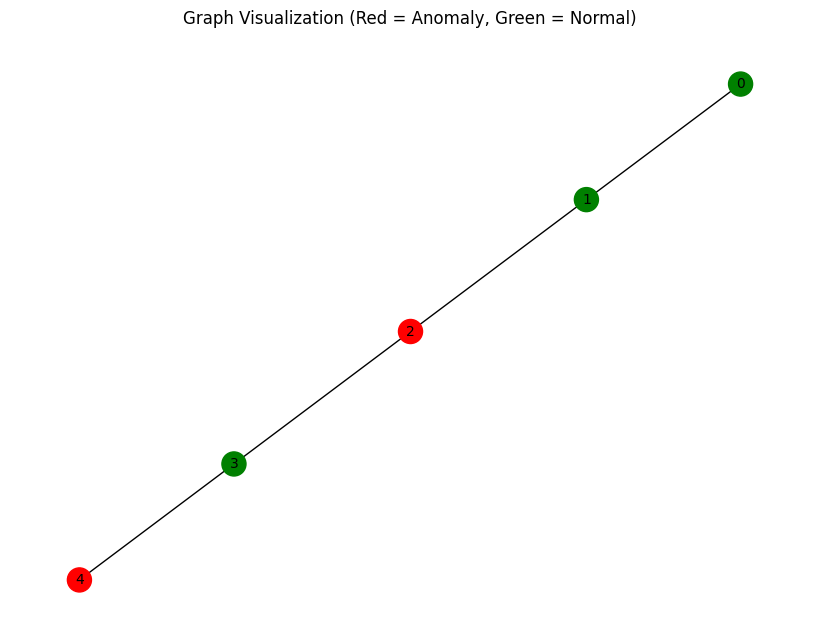

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert PyG data to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Set node colors based on labels (e.g., 0 = normal, 1 = anomaly)
node_colors = ['red' if label == 1 else 'green' for label in data.y.tolist()]

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw(G, node_color=node_colors, with_labels=True, node_size=300, font_size=10)
plt.title("Graph Visualization (Red = Anomaly, Green = Normal)")
plt.show()

In [19]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

# Step 1: Load data
df = pd.read_csv("simulated_river_data_large.csv")  
features = df[['pH', 'turbidity', 'temperature', 'DO']].values
labels = df['anomaly'].values

# Step 2: Convert to tensors
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# Step 3: Build kNN graph (e.g., k = 3)
edge_index = knn_graph(x, k=3)

# Step 4: Create PyG data object
data = Data(x=x, edge_index=edge_index, y=y)

# Step 5: Visualize with NetworkX
G = nx.Graph()
edge_list = data.edge_index.t().tolist()
G.add_edges_from(edge_list)

# Optional: color nodes by label
color_map = ['red' if label == 1 else 'skyblue' for label in y]

# Plot graph structure
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color='gray')
plt.title("Graph from CSV (anomalies in red)")
plt.show()

ImportError: 'knn_graph' requires 'torch-cluster'

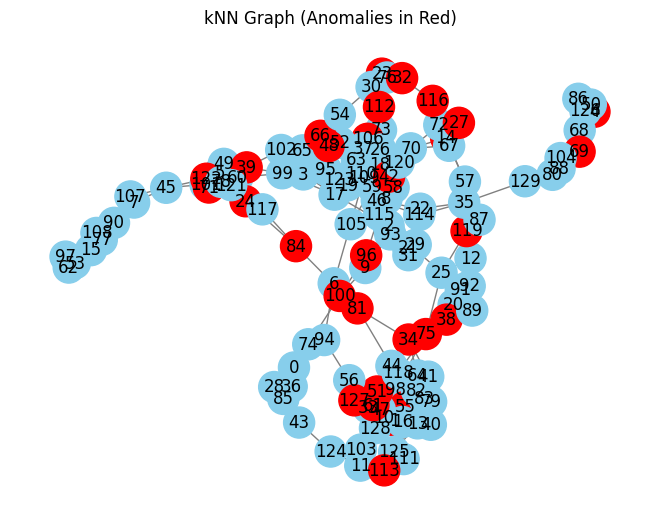

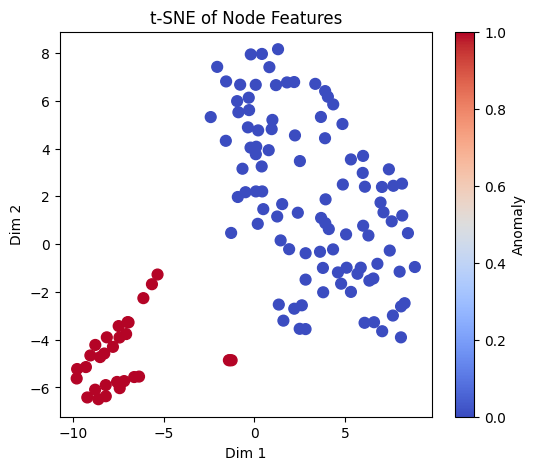

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE


df = pd.read_csv("simulated_river_data_large.csv")  
features = df[['pH', 'turbidity', 'temperature', 'DO']].values
labels = df['anomaly'].values

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)


k = 3
nbrs = NearestNeighbors(n_neighbors=k+1).fit(features)
_, indices = nbrs.kneighbors(features)


source_nodes = []
target_nodes = []

for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:  
        source_nodes.append(i)
        target_nodes.append(j)

edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


data = Data(x=x, edge_index=edge_index, y=y)


G = nx.Graph()
edge_list = data.edge_index.t().tolist()
G.add_edges_from(edge_list)

color_map = ['red' if label == 1 else 'skyblue' for label in y]

pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=500, edge_color='gray')
plt.title("kNN Graph (Anomalies in Red)")
plt.show()


tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(features)

plt.figure(figsize=(6, 5))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm', s=60)
plt.title("t-SNE of Node Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Anomaly')
plt.show()

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import time

CSV_FILE = "river_data_large.csv"

app = dash.Dash(_name_)
app.title = "Real-Time Pollution Dashboard"

app.layout = html.Div(children=[
    html.H1("Real-Time Pollution Dashboard", style={'textAlign': 'center'}),

    dcc.Interval(
        id='interval-component',
        interval=5*1000,  
        n_intervals=0
    ),

    dcc.Graph(id='pollution-graph'),

    html.Div([
        dcc.Dropdown(id='sensor-dropdown', placeholder='Select Sensor ID'),
        dcc.Graph(id='sensor-trend')
    ], style={'marginTop': '50px'})
])


@app.callback(
    Output('pollution-graph', 'figure'),
    Input('interval-component', 'n_intervals')
)
def update_pollution_map(n):
    try:
        df = pd.read_csv(CSV_FILE)

        latest = df.sort_values('timestamp').drop_duplicates('sensor_id', keep='last')

        fig = px.scatter_mapbox(latest,
                                lat="lat", lon="lon",
                                color="pollution_level",
                                size="pollution_level",
                                hover_name="sensor_id",
                                zoom=10,
                                mapbox_style="carto-positron",
                                title="Latest Pollution Levels by Sensor")
        return fig
    except Exception as e:
        return px.scatter(title="Error loading data: " + str(e))


@app.callback(
    [Output('sensor-dropdown', 'options'),
     Output('sensor-dropdown', 'value')],
    Input('interval-component', 'n_intervals')
)
def update_dropdown(n):
    df = pd.read_csv(CSV_FILE)
    options = [{'label': sid, 'value': sid} for sid in df['sensor_id'].unique()]
    value = options[0]['value'] if options else None
    return options, value


@app.callback(
    Output('sensor-trend', 'figure'),
    [Input('sensor-dropdown', 'value'),
     Input('interval-component', 'n_intervals')]
)
def update_sensor_graph(sensor_id, n):
    df = pd.read_csv(CSV_FILE)
    if sensor_id:
        df = df[df['sensor_id'] == sensor_id]
        fig = px.line(df, x='timestamp', y='pollution_level', title=f'Trends for Sensor {sensor_id}')
        return fig
    return px.line(title="No Sensor Selected")


if _name_ == '_main_':
    app.run_server(debug=True)

NameError: name '_name_' is not defined